Files already downloaded and verified
Files already downloaded and verified
Client 9 finished round 1 with accuracy: 0.0102
Client 19 finished round 1 with accuracy: 0.0092
Client 18 finished round 1 with accuracy: 0.0139
Client 3 finished round 1 with accuracy: 0.0168
Client 12 finished round 1 with accuracy: 0.0098
Client 1 finished round 1 with accuracy: 0.0160
Client 5 finished round 1 with accuracy: 0.0148
Client 11 finished round 1 with accuracy: 0.0145
Client 2 finished round 1 with accuracy: 0.0104
Client 8 finished round 1 with accuracy: 0.0171
Client 7 finished round 1 with accuracy: 0.0089
Client 4 finished round 1 with accuracy: 0.0165
Client 13 finished round 1 with accuracy: 0.0115
Client 0 finished round 1 with accuracy: 0.0165
Client 15 finished round 1 with accuracy: 0.0167
Client 6 finished round 1 with accuracy: 0.0105
Client 14 finished round 1 with accuracy: 0.0222
Client 10 finished round 1 with accuracy: 0.0179
Client 16 finished round 1 with accuracy: 0.0091
Cli

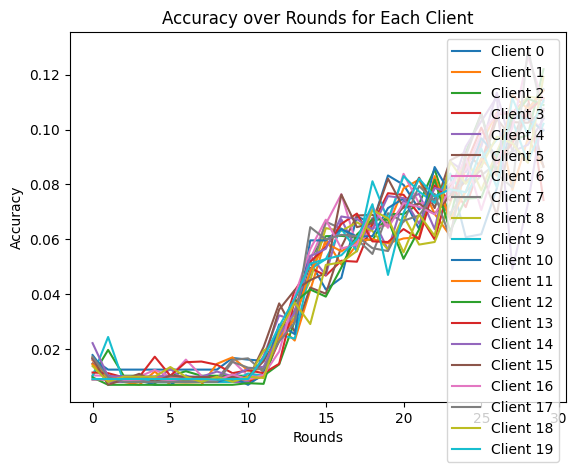

In [7]:
import torch
from torchvision.datasets import CIFAR100
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.multiprocessing import Manager
import threading
import random
import matplotlib.pyplot as plt

# Define the GossipNet model
class GossipNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, 3, padding=1)  # 3 input channels for RGB images
        self.conv2 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, 3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()

        # Initializing the fully connected layer dynamically based on image size
        self.fc = torch.nn.Linear(self._get_fc_input_size(), 100)  # 100 output classes for CIFAR-100

    def _get_fc_input_size(self):
        # Create a dummy tensor to compute the output size after convolutions and pooling
        dummy_input = torch.zeros(1, 3, 32, 32)  # CIFAR-100 images are 32x32x3
        dummy_output = self.pool(self.conv3(self.conv2(self.conv1(dummy_input))))
        return dummy_output.numel()  # Number of elements in the flattened tensor

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.flatten(x)
        return self.fc(x)

    def apply_parameters(self, parameters):
        with torch.no_grad():
            for name, param in parameters.items():
                layer = getattr(self, name)
                layer.weight.data.copy_(param['weight'])
                layer.bias.data.copy_(param['bias'])

    def get_parameters(self):
        parameters = {}
        for name, layer in self.named_children():
            if isinstance(layer, (torch.nn.Conv2d, torch.nn.Linear)):
                parameters[name] = {
                    'weight': layer.weight.data.clone(),
                    'bias': layer.bias.data.clone()
                }
        return parameters

    def fit(self, dataset, epochs, lr):
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        for _ in range(epochs):
            for images, labels in dataloader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self(images)
                loss = F.cross_entropy(outputs, labels)
                loss.backward()
                optimizer.step()

    def evaluate(self, dataset):
        dataloader = DataLoader(dataset, batch_size=batch_size)
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total

# Function to convert parameters to CPU
def cpu_parameters(parameters):
    return {layer: {'weight': param['weight'].cpu().clone(), 'bias': param['bias'].cpu().clone()}
            for layer, param in parameters.items()}

# Function to aggregate parameters from neighbors
def aggregate_parameters(parameters_list):
    aggregated_params = {}
    for layer in parameters_list[0].keys():
        weights = [params[layer]['weight'] for params in parameters_list]
        biases = [params[layer]['bias'] for params in parameters_list]
        aggregated_params[layer] = {
            'weight': sum(weights) / len(weights),
            'bias': sum(biases) / len(biases),
        }
    return aggregated_params

# Client class for gossip learning
class Client:
    def __init__(self, client_id, dataset, shared_memory, timestamps, neighbor_dict):
        self.client_id = client_id
        self.dataset = dataset
        self.shared_memory = shared_memory
        self.timestamps = timestamps
        self.neighbor_dict = neighbor_dict
        self.history = []  # To track accuracy over rounds

    def train(self, parameters):
        net = GossipNet().to(device)
        net.apply_parameters(parameters)
        net.fit(self.dataset, epochs_per_client, learning_rate)
        return net.get_parameters(), net

    def update_shared_memory(self, parameters):
        self.shared_memory[self.client_id] = cpu_parameters(parameters)
        self.timestamps[self.client_id] += 1

    def get_accuracy(self, net):
        accuracy = net.evaluate(dev_dataset)
        self.history.append(accuracy)
        return accuracy

# Function to train a client asynchronously
def train_asynchronously(client_id, client, max_rounds):
    for round_num in range(max_rounds):
        # Dynamically fetch neighbors
        neighbors = random.sample(range(num_clients), random.randint(1, num_clients - 1))
        client.neighbor_dict[client_id] = neighbors

        # Collect parameters from neighbors
        available_params = [
            client.shared_memory[neighbor] for neighbor in neighbors
            if neighbor in client.shared_memory
            and abs(client.timestamps[client_id] - client.timestamps[neighbor]) <= timestamp_threshold
        ]

        # Aggregate parameters from neighbors or use default
        aggregated_params = aggregate_parameters(available_params) if available_params else GossipNet().get_parameters()

        # Train client with aggregated parameters and update shared memory
        updated_params, net = client.train(aggregated_params)
        client.update_shared_memory(updated_params)

        # Track accuracy for the client
        accuracy = client.get_accuracy(net)
        print(f"Client {client_id} finished round {round_num + 1} with accuracy: {accuracy:.4f}")

# Load CIFAR-100 dataset
train_dataset = CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_dataset, dev_dataset = random_split(train_dataset, [int(0.83 * len(train_dataset)), int(0.17 * len(train_dataset))])

# Hyperparameters
num_clients = 20
rounds = 30
batch_size = 64
epochs_per_client = 3
learning_rate = 2e-2
timestamp_threshold = 2  # Define the threshold for timestamp difference

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize clients and shared resources
examples_per_client = len(train_dataset) // num_clients
client_datasets = random_split(train_dataset, [examples_per_client] * num_clients)

manager = Manager()
shared_memory = manager.dict()
timestamps = manager.dict({i: 0 for i in range(num_clients)})
neighbor_dict = manager.dict({i: [] for i in range(num_clients)})

clients = [
    Client(i, client_datasets[i], shared_memory, timestamps, neighbor_dict)
    for i in range(num_clients)
]

# Train clients asynchronously
threads = []
for client_id, client in enumerate(clients):
    thread = threading.Thread(target=train_asynchronously, args=(client_id, client, rounds))
    threads.append(thread)
    thread.start()

# Wait for all threads to finish
for thread in threads:
    thread.join()

# Plot accuracy for each client
for client_id, client in enumerate(clients):
    plt.plot(client.history, label=f"Client {client_id}")

plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Accuracy over Rounds for Each Client')
plt.legend()
plt.show()
